In [1]:
%%capture --no-stderr
!pip install yfinance
!pip install lxml_html_clean 
!pip install requests_html

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from dateutil.relativedelta import relativedelta
import requests
from requests_html import HTMLSession
import matplotlib.pyplot as plt

# Momentum trading strategy
Momentum trading involves buying or selling assets based on recent price trends, with the expectation that these trends will continue. When an asset shows an upward trend, it often attracts more investors, which can further drive up its price. This momentum persists until a critical mass of sellers enters the market, reversing the trend and pushing the price lower.

This strategy takes advantage of market herding behavior, where traders tend to follow the majority. During strong trends, many investors may join the trend, amplifying the momentum.

To effectively use this strategy, it's important to time the entry and exit points of the momentum. Various technical indicators can assist in this:

* **Volume:** High trading volume often signals strong interest in an asset and can indicate the start of a new trend, while low volume might suggest a potential reversal.
* **Volatility:** High volatility can offer profitable trading opportunities if the price moves favorably, but it also increases the risk of significant losses. Managing volatility is crucial.
* **Time Frame:** The time frame indicates how long the identified trend is expected to last.

Although both trend-following and momentum trading strategies are based on momentum, they differ in approach. Momentum trading is cross-sectional, comparing momentum across different assets at a specific point in time and investing in those with the highest momentum. In contrast, trend-following focuses on time series momentum, relying on an asset's historical performance over time.

The momentum trading strategy uses a lookback window to identify the best-performing assets over a set period. An additional lookahead window determines the holding period for a position once a trading decision is made.

We will perform our analysis on different assets: Dow Jones, S&P 500 and cryptocurrencies. First, we define a function that set up the strategy and calculates its return and its Sharpe ratio.

In [30]:
def get_sharpe_ratio(monthly_returns, lookback_window_size=6, lookahead_window_size=1, nb_quantiles=5, riskfree_rate=.04, plot=True):
    """ Function that sets up a momentum strategy and computes (i) the return and (ii) the Sharpe ratio of the strategy"""
    past_returns = (monthly_returns+1).rolling(lookback_window_size).apply(np.prod)-1 #compound returns over the last lookback_window_size months
    past_returns.dropna(axis=0, inplace=True) #drop the first lookback_window_size-1 lines
    evaluation_returns = (monthly_returns+1).rolling(lookahead_window_size).apply(np.prod)-1    #compound returns over each lookahead_window_size months
    evaluation_returns.dropna(axis=0, inplace=True) 
    momentum_returns = pd.DataFrame(columns=['Return'], index=past_returns.index)
    #for each date we create a portfolio where we long the best performers of the last lookback_window_size months and short the worst performers
    #we do not take the last lookahead_window_size dates because we will not be able to evaluate our portfolio for these dates
    #we do not modify our portfolio during the evaluation period so each trade is separated by lookahead_window_size months
    for i in range(0, past_returns.index.shape[0]-lookahead_window_size, lookahead_window_size): 
        observation_date = past_returns.index[i]
        observation_returns = past_returns.loc[observation_date].reset_index() #returns of the last lookback_window_size months at the observation date
        observation_returns['Quantile'] = pd.qcut(observation_returns.iloc[:, 1], nb_quantiles, labels=False) # we create quantile to identify the best performers and the worst performers
        long_stocks = observation_returns.loc[observation_returns["Quantile"]==nb_quantiles-1, "Ticker"].values # we long the best performers
        short_stocks = observation_returns.loc[observation_returns["Quantile"]==0, "Ticker"].values # we short the worst performers
        evaluation_date = observation_date.replace(day=1)+relativedelta(months=lookahead_window_size+1, days=-1) #last day of next month
        long_returns = evaluation_returns.loc[evaluation_date, long_stocks] # returns of long stocks over the lookahead_window_size future months
        short_returns = evaluation_returns.loc[evaluation_date, short_stocks]
        momentum_returns.loc[evaluation_date] = long_returns.mean() - short_returns.mean() #we assume an equally-weighted portfolio
    momentum_returns.dropna(axis=0, inplace=True)
    nb_years= relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).years + relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).months/12 + relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).days/365 #Number of years in the trading period
    annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
    annualized_vol = (momentum_returns['Return'].std()/nb_years)**.5
    sharpe_ratio = (annualized_return- riskfree_rate)/annualized_vol
    if plot:
        momentum_returns_plot = pd.concat([pd.DataFrame({'Return':0}, index=[momentum_returns.index[0]-relativedelta(months=1)]), momentum_returns])
        (1+momentum_returns_plot['Return']).cumprod().plot()
        plt.title('Evolution of the value of the momentum strategy')
        plt.ylabel('Cumulative return')
        plt.show()
    return sharpe_ratio

### Dow Jones

We use the Dow Jones index as the reference universe. We scrap the constituents from the wikipedia page.

In [4]:
def get_dji_tickers():
    """ Function that scrapes the wikipedia page of the Dow Jones Industrial Average to get the list of the tickers of the companies in the index"""
    try:
        url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:101.0) Gecko/20100101 Firefox/101.0',
        'Accept': 'application/json',
        'Accept-Language': 'en-US,en;q=0.5',
        }
        # Send GET request
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        # Get the symbols table
        tables = soup.find_all('table')
        # # Convert table to dataframe
        df = pd.read_html(str(tables))[1]
        return df['Symbol'].values.tolist()
    except:
        print('Error loading data')
        return None

Once we have the tickers, we download the data from Yahoo Finance.

In [5]:
start_date = "2016-01-01"
end_date = "2024-06-01"
tickers = get_dji_tickers()
df = yf.download(tickers, start=start_date, end=end_date)
df = df['Adj Close']

daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)

/tmp/ipykernel_36/2786304083.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables))[1]
[*********************100%%**********************]  30 of 30 completed


In [6]:
best_sharpe_ratio = 0
best_lookback_window_size = 0
best_lookahead_window_size = 0
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, plot=False)
        if(sharpe_ratio>best_sharpe_ratio):
            best_sharpe_ratio=sharpe_ratio
            best_lookback_window_size=lookback_window_size
            best_lookahead_window_size=lookahead_window_size

print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(best_lookback_window_size, best_lookahead_window_size, best_sharpe_ratio))

Lookback: 1 	 Lookahead: 6 	 Sharpe ratio: 0.42294340880612824


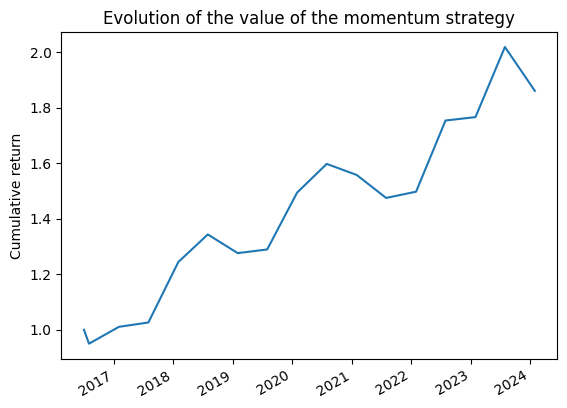

Sharpe ratio:  0.42294340880612824


In [7]:
print("Sharpe ratio: ", get_sharpe_ratio(monthly_returns, lookback_window_size=best_lookback_window_size, lookahead_window_size=best_lookahead_window_size, plot=True))

### S&P 500
We perform the same analysis with the S&P 500 index.

In [8]:
def get_spx_tickers():
    try:
        url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:101.0) Gecko/20100101 Firefox/101.0',
        'Accept': 'application/json',
        'Accept-Language': 'en-US,en;q=0.5',
        }
        # Send GET request
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        # Get the symbols table
        tables = soup.find_all('table')
        # # Convert table to dataframe
        df = pd.read_html(str(tables))[0]
        return df['Symbol'].values.tolist()
    except:
        print('Error loading data')
        return None

In [9]:
start_date = "2016-01-01"
end_date = "2024-06-01"
tickers = get_spx_tickers()
df = yf.download(tickers, start=start_date, end=end_date)
df = df['Adj Close']

daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)
stocks_to_delete = monthly_returns.columns[(monthly_returns==0).sum()>0] #drop the stocks that have a return zero during at least one month
print("{} stocks deleted".format(len(stocks_to_delete)))
monthly_returns = monthly_returns.drop(stocks_to_delete, axis=1) 

/tmp/ipykernel_36/2188847483.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables))[0]
[******************    37%%                      ]  185 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2016-01-01 -> 2024-06-01)


[*********************100%%**********************]  503 of 503 completed


32 stocks deleted


In [10]:
best_sharpe_ratio = 0
best_lookback_window_size = 0
best_lookahead_window_size = 0
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, plot=False)
        if(sharpe_ratio>best_sharpe_ratio):
            best_sharpe_ratio=sharpe_ratio
            best_lookback_window_size=lookback_window_size
            best_lookahead_window_size=lookahead_window_size
        if(sharpe_ratio>0):
            print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(lookback_window_size, lookahead_window_size, sharpe_ratio))
            
print("\n")
print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(best_lookback_window_size, best_lookahead_window_size, best_sharpe_ratio))

Lookback: 2 	 Lookahead: 3 	 Sharpe ratio: 0.0012946387557417123
Lookback: 10 	 Lookahead: 3 	 Sharpe ratio: 0.10030608454991438


Lookback: 10 	 Lookahead: 3 	 Sharpe ratio: 0.10030608454991438


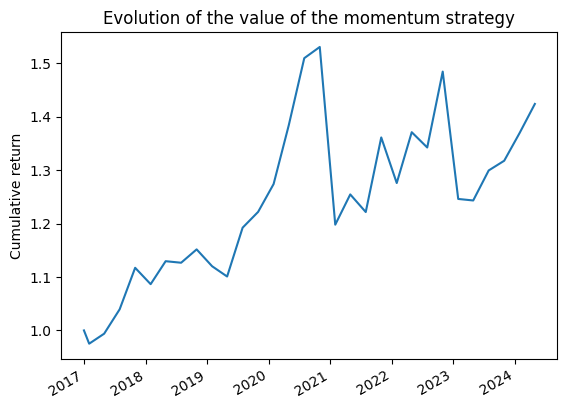

Sharpe ratio:  0.10030608454991438


In [11]:
print("Sharpe ratio: ", get_sharpe_ratio(monthly_returns, lookback_window_size=best_lookback_window_size, lookahead_window_size=best_lookahead_window_size, plot=True))

This result appears to be quite surprising as it is particularly bad compared to the Dow Jones' result.

### Cryptocurrencies

We perform a similar analysis on cryptocurrencies. For this asset class, we get the tickers of the first 100 cryptocurrencies in capitalization from Yahoo Finance.

In [24]:
session = HTMLSession()
num_currencies=100
resp = session.get(f"https://finance.yahoo.com/markets/crypto/all/?start=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
df['Symbol'] = df['Symbol'].str.split().str[0]
crypto_tickers = df.Symbol.tolist()

In [26]:
start_date = "2021-01-01" # we reduce the time frame because no data was available for most of cryptocurrencies in 2016
end_date = "2024-06-01"
df = yf.download(crypto_tickers, start=start_date, end=end_date)
df = df['Adj Close']

[*********************100%%**********************]  100 of 100 completed


In [28]:
daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)
crypto_to_delete = monthly_returns.columns[(monthly_returns==0).sum()>0] #drop the cryptos that have a return zero during at least one month
print("{} cryptocurrencies deleted".format(len(crypto_to_delete)))
monthly_returns = monthly_returns.drop(crypto_to_delete, axis=1) 

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


46 cryptocurrencies deleted


In [33]:
%%capture

best_sharpe_ratio = 0
best_lookback_window_size = 0
best_lookahead_window_size = 0
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, plot=False)
        if(sharpe_ratio>best_sharpe_ratio):
            best_sharpe_ratio=sharpe_ratio
            best_lookback_window_size=lookback_window_size
            best_lookahead_window_size=lookahead_window_size

print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(best_lookback_window_size, best_lookahead_window_size, best_sharpe_ratio))

2.0


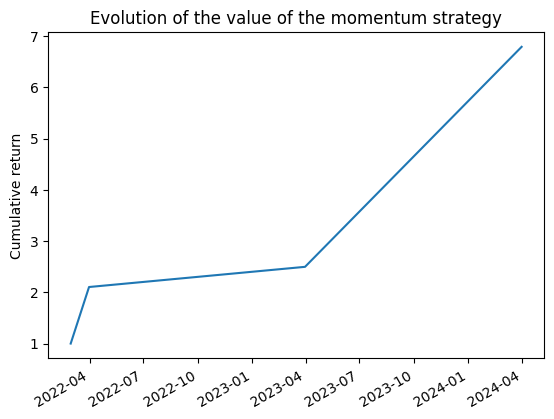

Sharpe ratio:  2.5224872986138105


In [34]:
print("Sharpe ratio: ", get_sharpe_ratio(monthly_returns, lookback_window_size=best_lookback_window_size, lookahead_window_size=best_lookahead_window_size, plot=True))

This particularly good result may due to the bull market in the beginning of 2024.

# MACD (Moving Average Convergence Divergence)

The MACD indicator is designed to highlight changes in the strength, direction, momentum, and duration of a stock's price trend.

The MACD is based on three key time series: the MACD line, the "signal" line, and the "divergence" series, which is the difference between the two. The MACD line is calculated as the difference between a short-term exponential moving average (EMA) and a long-term EMA of the price series. The signal line is an EMA of the MACD line itself.

The MACD indicator relies on three time parameters, corresponding to the periods of the three EMAs. The notation "MACD(a, b, c)" indicates that the MACD line is derived from EMAs with periods a and b, while the signal line is an EMA of the MACD line with period c. Typically, these parameters are measured in days, with the most common settings being 12, 26, and 9 days, represented as MACD(12, 26, 9). The 12-period EMA is more responsive to recent price changes, providing sensitivity to short-term price movements. In contrast, the 26-period EMA is smoother and reacts more slowly, capturing longer-term trends. This combination helps the MACD identify potential shifts in momentum across various timeframes.

For MACD, we focus on Apple's stock.

In [35]:
df = yf.download(['AAPL'], start="2021-01-01", end="2024-05-31")

[*********************100%%**********************]  1 of 1 completed


In [36]:
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

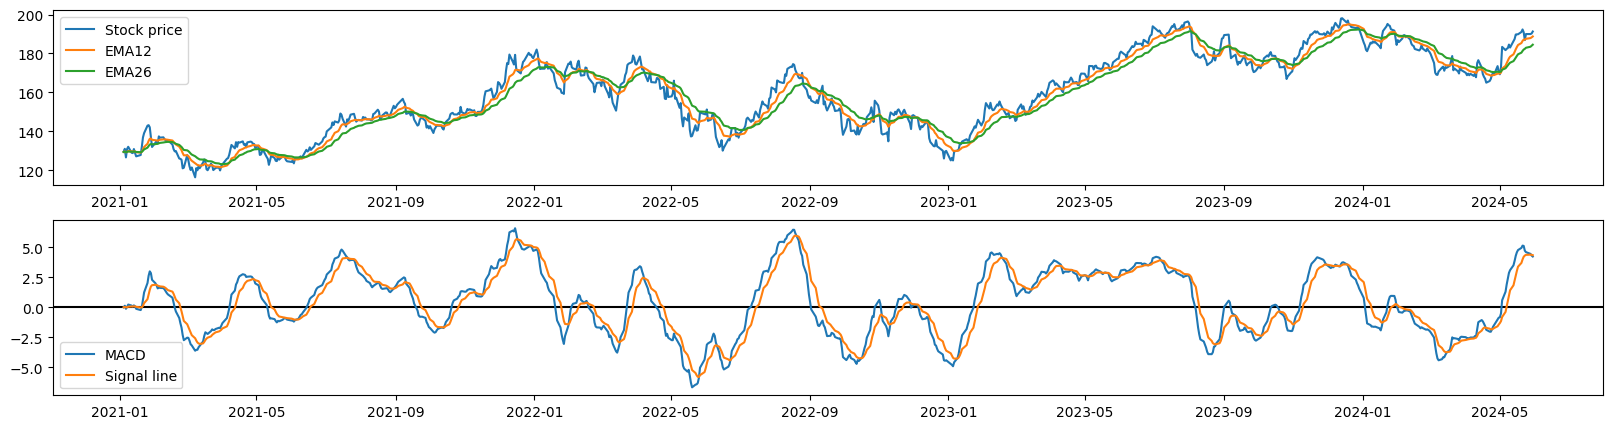

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(df.index, df['Close'], label="Stock price")
plt.plot(df.index, df['EMA12'], label="EMA12")

plt.plot(df.index, df['EMA26'], label="EMA26")
plt.legend()
plt.subplot(2,1,2)
plt.axhline(color='black')
plt.plot(df.index, df['MACD'], label="MACD")
plt.plot(df.index, df['Signal_Line'], label="Signal line")
plt.legend()

Each time the MACD line crosses the x axis means the two EMA time series cross each other. When the MACD line is above the x axis, the fast EMA is above the slow EMA, meaning the price is bullish. Conversely, when the MACD line is below the x axis, the price is bearish. 

When the MACD line is above its EMA (the signal line), the price is particularly bullish and we can consider this a trading signal for buying the stock. 

# RSI (Relative Strength Index)

This section will be implemented in the future.

Useful starting ressources: https://en.wikipedia.org/wiki/Relative_strength_index

# Trend following

This section will be implemented in the future.

Useful starting ressources: Quantitative trading strategies using Python of Peng Liu

# References
Wikipedia pages of [Dow Jones](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average), [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) and [MACD](https://en.wikipedia.org/wiki/MACD])